In [1]:
using Gadfly
using Colors
#set_default_plot_size(25cm, 8cm)

# Parameter Estimation in a Cascading Latent Force Model

### Example: brine tank cascade

(see [here](./Cascading%20Latent%20Force%20Model.ipynb) for model set-up and inference, [model reference](http://www.math.utah.edu/~gustafso/2250systems-de.pdf))

```
    ↓ ___
   | (1) |__
   |_______↴|____
        |        |___
        |  (2)    __↴|_________
        |________| |           |
                   |   (3)     |
                   |_____     _|
                         | ↓ |
```

The system is modelled as a joint Gaussian distribution, giving the following single latent force model:

$$
    \frac{\mathrm{d}}{\mathrm{d}t}\mathbf{f}(t) = \mathbf{A}\mathbf{f}(t) + \mathbf{L}u(t)
$$
$$
    y(t) = \mathbf{H}\mathbf{f}(t) + \nu(t)
$$

Where 

$$ \mathbf{f}(t) = \begin{bmatrix}f_1(t)\\ f_2(t)\\ f_3(t)\end{bmatrix}, \qquad
    \mathbf{A} = \begin{bmatrix}
        a_1 & 0 & 0 \\
        -a_1 & a_2 & 0 \\ 
        0 & -a_2 & a_3
    \end{bmatrix}, \qquad \mathbf{L} = \begin{bmatrix}1 \\ 0 \\ 0\end{bmatrix}
$$

$$
    \mathbf{H} = \begin{bmatrix}0 & 0 & -a_3\end{bmatrix}
$$

## Modelling

This is based on the Cascading Latent Force Model example, with scripts in `CLFM_demo.jl`

In [2]:
include("CLFM_demo.jl")

params = default_params()

#= This is equiv, with default params:
y = generate_observations(ts)
f, P = infer(t,y,ts)
=#
df = demo(𝛉=params, as_dataframe=:true)

head(df)

6×6 DataFrames.DataFrame. Omitted printing of 6 columns
│ Row │ ├─────┼
│ 1   │ │ 2   │ │ 3   │ │ 4   │ │ 5   │ │ 6   │

### Plot system variables and latent force posterior

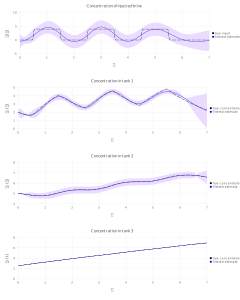

In [3]:
set_default_plot_size(24cm, 30cm)
plot_estimate(df[:mean], df[:cov], df[:t], 𝛉=params)

# This is also saved to file by demo() 
#=
open("CLFM_demo_smoothed.svg") do f
    display("image/svg+xml", readstring(f))
end
=#

## Parameter Estimation

Use particle Gibbs to estimate parameters, first of GP kernel, i.e. $\mathscr{l}$ and $\sigma_\kappa^2$, then include system parameters

In [4]:
using Turing
using Mamba: describe, plot

[Turing]: AD chunk size is set as 40


We generate some observations, using the default parameters

In [5]:
θ = default_params(as_dict=true)

nₜ = 1000
t  = linspace(0., 7., nₜ)
ix = 1:10:nₜ

𝐲 = generate_observations(t[ix], 𝛉 = θ);

Turing models used here. Put Inverse Gamma priors over variables -- _not sure if this is right_

Likelihood is a multivariate normal over the observations, with mean and cov output from KF/RTS in obs space.

Also don't get full covariance of likelihood, only diagonal (not sure if important, implementation slow / not working).

In [6]:
@model clfm_known_rate(y) = begin
    
    l  ~ InverseGamma(2, 0.5)
    σ² ~ InverseGamma(2, 4)
    
    θ = default_params(as_dict=true)
    
    θ["Kernel Parameters"] = (√3/l, l, σ²)
    
    f, P, _, _, G = infer(t, y, t[ix], 𝛉=θ, rts=:true, gain=:true)
    
    #y ~ likelihood(f[ix], P[ix], 𝐆=G[ix], 𝛉 = θ) #mvnormal
    y ~ likelihood(f[ix], P[ix], 𝛉 = θ, noiseless=:false) #mvnormal
    
    return l, σ², a₁, a₂, a₃
end

@model clfm_unknown_rate(y) = begin
    l  ~ InverseGamma(2, 0.5)
    σ² ~ InverseGamma(2, 4)
    a₁ ~ InverseGamma(2, 0.5)
    a₂ ~ InverseGamma(2, 0.25)
    a₃ ~ InverseGamma(2, 0.125)
    
    θ = default_params(as_dict=true)
    
    θ["Output Rates"] = (-a₁, -a₂, -a₃)
    θ["Kernel Parameters"] = (√3/l, l, σ²)
    
    
    f, P, _, _, G = infer(t, y, t[ix], 𝛉=θ, rts=:true, gain=:true)
    
    
    #y ~ likelihood(f[ix], P[ix], 𝐆=G[ix], 𝛉 = θ) #mvnormal
    y ~ likelihood(f[ix], P[ix], 𝛉 = θ, noiseless=:false) #mvnormal
    
    return l, σ², a₁, a₂, a₃
end

clfm_unknown_rate (generic function with 2 methods)

In [7]:
c1 = sample(clfm_known_rate(𝐲), PG(25, 1000))

[Turing]:  Assume - `l` is a parameter
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `σ²` is a parameter
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Observe - `y` is an observation
 @~(::ANY, ::ANY) at compiler.jl:57


[PG] Sampling...100%  ETA: 0:00:01

Object of type "Turing.Chain"

Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

[0.192662 1.91288 6.37524 0.0; 0.101329 0.439858 8.17446 0.0; … ; 0.825844 0.321349 57.3662 0.0; 0.730252 0.36796 73.1419 0.0]

In [8]:
describe(c1)

[PG] Finished with
  Running time    = 369.42670272600014;


[PG] Sampling...100% Time: 0:06:10


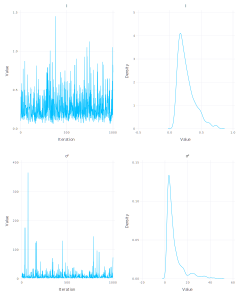

Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

Empirical Posterior Estimates:
            Mean         SD       Naive SE       MCSE         ESS   
      l  0.27363786  0.16815897 0.0053176536 0.0050793160 1000.00000
elapsed  0.36942670  0.06889436 0.0021786309 0.0029388827  549.54441
     σ² 10.47661345 20.44430470 0.6465056802 0.8797346943  540.05905
     lp  0.00000000  0.00000000 0.0000000000 0.0000000000        NaN

Quantiles:
            2.5%       25.0%      50.0%      75.0%      97.5%   
      l 0.086323653 0.15836007 0.22688118 0.33576444  0.75157162
elapsed 0.290239555 0.30656509 0.39087081 0.39944648  0.43795222
     σ² 1.658856740 3.30128781 5.40590830 9.76337237 48.14532917
     lp 0.000000000 0.00000000 0.00000000 0.00000000  0.00000000



In [9]:
ps = Array{Gadfly.Plot}(2,2)
p = plot(c1)

k = [1,3]
for i = 1:2
    ps[i,1] = p[1,k[i]]
    ps[i,2] = p[2,k[i]]
end

gridstack(ps)

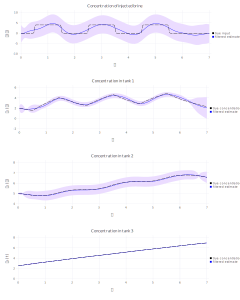

In [10]:
l,σ² = [median(c1.value[:,i,1]) for i ∈ k]

θ = default_params()
θ["Kernel Parameters"] = (√3 / l, l, σ²)

f, P, _, _, G = infer(t, 𝐲, t[ix], 𝛉=θ, rts=:true, gain=:true)

display(plot_estimate(f, P, t, 𝛉=default_params()))

In [11]:
c2 = sample(clfm_unknown_rate(𝐲), PG(25, 1000))

[Turing]:  Assume - `l` is a parameter (ignoring `l` found in global scope)
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `σ²` is a parameter (ignoring `σ²` found in global scope)
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `a₁` is a parameter
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `a₂` is a parameter
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `a₃` is a parameter
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Observe - `y` is an observation
 @~(::ANY, ::ANY) at compiler.jl:57


[PG] Sampling...100%  ETA: 0:00:01

Object of type "Turing.Chain"

Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

[0.291604 0.174571 … 0.0 0.517996; 0.291604 0.174571 … 0.0 0.45602; … ; 0.410738 0.166725 … 0.0 0.487013; 0.410738 0.166725 … 0.0 0.330153]

In [16]:
describe(c2)

Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

Empirical Posterior Estimates:
           Mean         SD         Naive SE         MCSE          ESS   
      l 0.21857228 0.1312463237 0.004150373173 0.037737956058  12.095325
     a₃ 0.16712625 0.0013318158 0.000042115715 0.000088487450 226.529617
     a₁ 0.46684588 0.3867937496 0.012231492336 0.086509641221  19.990786
     a₂ 0.24821348 0.0104241435 0.000329640361 0.000769531547 183.496551
     σ² 2.66720653 1.3310035134 0.042090026759 0.387688568847  11.786705
     lp 0.00000000 0.0000000000 0.000000000000 0.000000000000        NaN
elapsed 0.40507044 0.0547008929 0.001729794116 0.003497266648 244.642180

Quantiles:
           2.5%       25.0%      50.0%      75.0%      97.5%  
      l 0.11514112 0.11514112 0.16194228 0.37248150 0.41073776
     a₃ 0.16516897 0.16672541 0.16710280 0.16710280 0.17001224
     a₁ 0.23943303 0.27715735 0.30695387 0.30695387 2.10802338
     a₂ 0.22127516 0.24784405 0.24784405 0

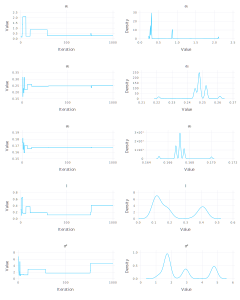

In [17]:
ps = Array{Gadfly.Plot}(5,2)
p = plot(c2)

k = [3,4,2,1,5]
for i = 1:5
    ps[i,1] = p[1,k[i]]
    ps[i,2] = p[2,k[i]]
end

gridstack(ps)

In [22]:
a₁,a₂,a₃,l,σ² = [mean(c2.value[:,i,1]) for i = 1:7][k]

5-element Array{Float64,1}:
 0.466846
 0.248213
 0.167126
 0.218572
 2.66721 

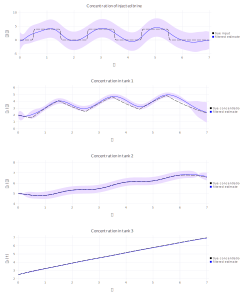

In [23]:
θ = default_params()
θ["Output Rates"] = (-a₁,-a₂,-a₃)
θ["Kernel Parameters"] = (√3 / l, l, σ²)

f, P, _, _, G = infer(t, 𝐲, t[ix], 𝛉=θ, rts=:true, gain=:true)

display(plot_estimate(f, P, t, 𝛉=default_params()))